## Final Project - SOLUTION

In this notebook, we build a ML model to predict the __Outcome Type__ field of our final project dataset.

1. <a href="#1">Read the dataset</a> (Given) 
2. <a href="#2">Train a model</a> (Implement)
    * <a href="#21">Exploratory Data Analysis</a>
    * <a href="#22">Select features to build the model</a>
    * <a href="#23">Data processing</a>
    * <a href="#24">Model training</a>
3. <a href="#3">Make predictions on the test dataset</a> (Implement)
4. <a href="#4">Evaluate accuracy</a> (Given)

__Austin Animal Center Dataset__:

In this exercise, we are working with pet adoption data from __Austin Animal Center__. We have two datasets that cover intake and outcome of animals. Intake data is available from [here](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Intakes/wter-evkm) and outcome is from [here](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Outcomes/9t4d-g238). 

In order to work with a single table, we joined the intake and outcome tables using the "Animal ID" column and created a training.csv, test_features.csv and y_test.csv files. Similar to our review dataset, we didn't consider animals with multiple entries to the facility to keep it simple. If you want to see the original datasets, they are available under `DATA/review` folder: Austin_Animal_Center_Intakes.csv, Austin_Animal_Center_Outcomes.csv.

__Dataset schema:__ 
- __Pet ID__ - Unique ID of pet
- __Outcome Type__ - State of pet at the time of recording the outcome. This is the value to predict. 
- __Sex upon Outcome__ - Sex of pet at outcome
- __Name__ - Name of pet 
- __Found Location__ - Found location of pet before entered the center
- __Intake Type__ - Circumstances bringing the pet to the center
- __Intake Condition__ - Health condition of pet when entered the center
- __Pet Type__ - Type of pet
- __Sex upon Intake__ - Sex of pet when entered the center
- __Breed__ - Breed of pet 
- __Color__ - Color of pet 
- __Age upon Intake Days__ - Age of pet when entered the center (days)
- __Time at Center__ - Time at center (0 = less than 30 days; 1 = more than 30 days). 


In [1]:
# #Upgrade dependencies
# !pip install --upgrade pip
# !pip install --upgrade scikit-learn

## 1. <a name="1">Read the datasets</a> (Given)
(<a href="#0">Go to top</a>)

Let's read the datasets into dataframes, using Pandas.

In [2]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")
  
training_data = pd.read_csv('../../DATA/final_project/training.csv')
test_data = pd.read_csv('../../DATA/final_project/test_features.csv')

print('The shape of the training dataset is:', training_data.shape)
print('The shape of the test dataset is:', test_data.shape)


The shape of the training dataset is: (71538, 13)
The shape of the test dataset is: (23846, 12)


## 2. <a name="2">Train a model</a> (Implement)
(<a href="#0">Go to top</a>)

 * <a href="#21">Exploratory Data Analysis</a>
 * <a href="#22">Select features to build the model</a>
 * <a href="#23">Data processing</a>
 * <a href="#24">Model training</a>

### 2.1 <a name="21">Exploratory Data Analysis</a> 
(<a href="#2">Go to Train a model</a>)

We look at number of rows, columns and some simple statistics of the dataset.

In [3]:
training_data.head(2)

,Pet ID,Outcome Type,Sex upon Outcome,Name,Found Location,Intake Type,Intake Condition,Pet Type,Sex upon Intake,Breed,Color,Age upon Intake Days,Time at Center
0,A745079,Transfer,Unknown,NaN,7920 Old Lockhart in Travis (TX),Stray,Normal,Cat,Unknown,Domestic Shorthair Mix,Blue,3,0
1,A801765,Transfer,Intact Female,NaN,5006 Table Top in Austin (TX),Stray,Normal,Cat,Intact Female,Domestic Shorthair,Brown Tabby/White,28,0


In [4]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71538 entries, 0 to 71537
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Pet ID                71538 non-null  object
 1   Outcome Type          71533 non-null  object
 2   Sex upon Outcome      71537 non-null  object
 3   Name                  44360 non-null  object
 4   Found Location        71538 non-null  object
 5   Intake Type           71538 non-null  object
 6   Intake Condition      71538 non-null  object
 7   Pet Type              71538 non-null  object
 8   Sex upon Intake       71537 non-null  object
 9   Breed                 71538 non-null  object
 10  Color                 71538 non-null  object
 11  Age upon Intake Days  71538 non-null  int64 
 12  Time at Center        71538 non-null  int64 
dtypes: int64(2), object(11)
memory usage: 7.1+ MB


Notice here that 'Name' has a lot of missing values. Let's go ahead and drop all rows where the name is missing with `dropna`; the parameter `subset` defines which column we want to consider for dropping, `axis` determines if the drop is row or column-wise and `inplace` refers to updating the dataframe directly (no need to re-assign it to a new variable).

In [5]:
training_data.dropna(subset = ['Name'], axis = 0, inplace = True)

#### Model features vs model target

In [6]:
# Split model target and features
model_target = 'Time at Center' # 0 & 1
model_features = training_data.columns.drop(model_target).tolist()

# Split model features between categorical and numerical features
categorical_features = training_data.select_dtypes(include='object').columns.tolist()
numerical_features = training_data.select_dtypes(include=np.number).columns.drop(model_target).tolist()

Plot histograms for all categorical features:

Pet ID


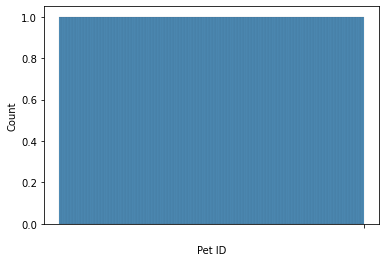

Outcome Type


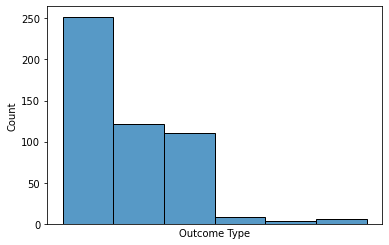

Sex upon Outcome


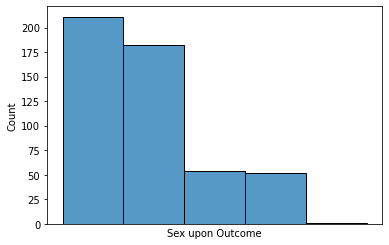

Name


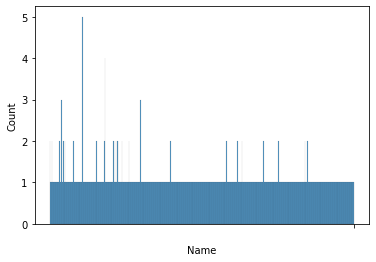

Found Location


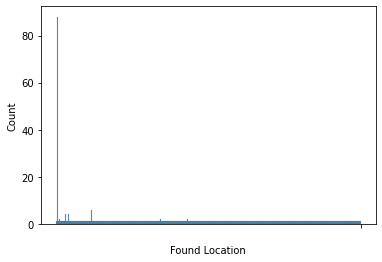

Intake Type


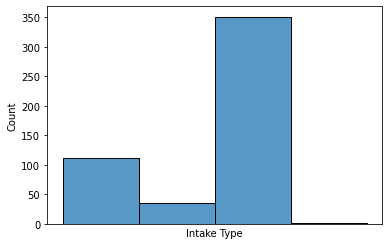

Intake Condition


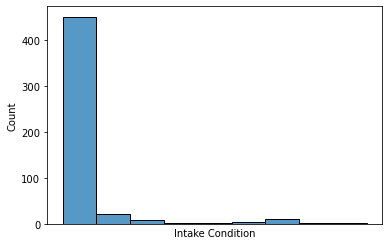

Pet Type


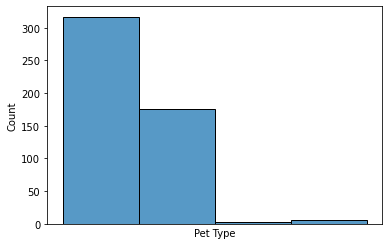

Sex upon Intake


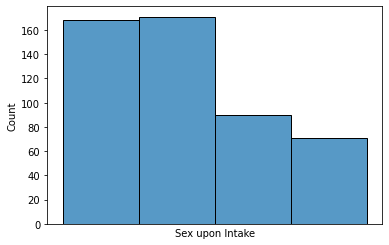

Breed


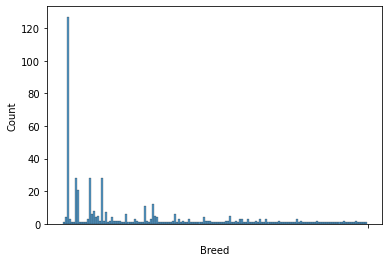

Color


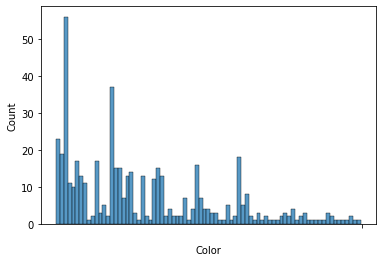

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (6,4))
for c in categorical_features:
    try:
        print(c)
        sns.histplot(training_data[str(c)].sample(500))
        plt.xticks(" ") # Stop python printing labels
        plt.show()
    except:
        print('Could not plot feature %s'%c)
        pass

#### Target Distribution

<AxesSubplot:>

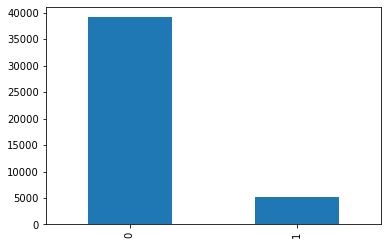

In [8]:
training_data[model_target].value_counts().plot.bar()

Upsample the underrepresented class:

In [9]:
print('Data set shape:', training_data.shape)

print('Class 0 samples in the data set:', sum(training_data[model_target] == 0))
print('Class 1 samples in the data set:', sum(training_data[model_target] == 1))

from sklearn.utils import shuffle

class_0_no = training_data[training_data[model_target] == 0]
class_1_no = training_data[training_data[model_target] == 1]

upsampled_class_1_no = class_1_no.sample(n=len(class_0_no), replace=True, random_state=42)

training_data_upsampled = pd.concat([class_0_no, upsampled_class_1_no])
training_data_upsampled = shuffle(training_data_upsampled)

print('Data set shape:', training_data_upsampled.shape)

print('Class 0 samples in the data set:', sum(training_data_upsampled[model_target] == 0))
print('Class 1 samples in the data set:', sum(training_data_upsampled[model_target] == 1))


Data set shape: (44360, 13)
Class 0 samples in the data set: 39137
Class 1 samples in the data set: 5223
Data set shape: (78274, 13)
Class 0 samples in the data set: 39137
Class 1 samples in the data set: 39137


#### Upsampled Data

<AxesSubplot:>

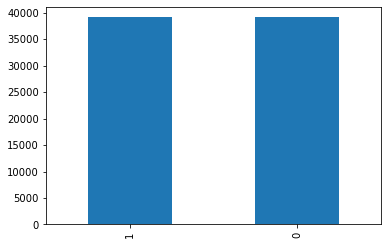

In [10]:
training_data_upsampled[model_target].value_counts().plot.bar()

### 2.2 <a name="22">Select features to build the model</a> 
(<a href="#2">Go to Train a model</a>)

Suggestion to use numerical features only (if you want to use categorical features, make sure to use [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) - models only understand numerical columns!).

Notice from EDA step that Pet ID, Name and Found Location are almost always unique and drop those columns from the features.

In [11]:
training_data_upsampled.drop(columns = ['Name', 'Pet ID', 'Found Location'], inplace = True)

### 2.3 <a name="23">Data Processing</a> 
(<a href="#2">Go to Train a model</a>)


Try different scalers and imputers.

In [12]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Initilizing transformers and model
imputer = SimpleImputer(strategy='mean')
scaler  = StandardScaler()

# Applying transformers
training_data_upsampled[numerical_features] = imputer.fit_transform(training_data_upsampled[numerical_features])
training_data_upsampled[numerical_features] = scaler.fit_transform(training_data_upsampled[numerical_features])

# Make sure to also apply transformer to test data
test_data = imputer.transform(test_data[numerical_features])


### 2.4 <a name="24">Model training/fitting</a> 
(<a href="#2">Go to Train a model</a>)

Suggestion to use:

`X_train = training_data[numerical_features]`   
`y_train = training_data[model_target]`

or if upsampled:

`X_train = training_data_upsampled[numerical_features]`   
`y_train = training_data_upsampled[model_target]`

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

X_train = training_data_upsampled[numerical_features]
y_train = training_data_upsampled[model_target]

# Trying different values of K in an automated way
K_values = [1, 2, 3, 4, 5, 6]

K_best = 0.0
train_score_best = 0.0
for K in K_values:
    classifier = KNeighborsClassifier(n_neighbors = K)
    classifier.fit(X_train, y_train)
    train_predictions = classifier.predict(X_train)
    train_acc = accuracy_score(y_train, train_predictions)
    print("K=%d, Validation accuracy: %f" % (K, train_acc))
    if train_acc > train_score_best:
        K_best = K
        train_score_best = train_acc
        
print("K_best=%d, Best Validation accuracy: %f" % (K_best, train_score_best))


K=1, Validation accuracy: 0.667003
K=2, Validation accuracy: 0.724046
K=3, Validation accuracy: 0.757225
K=4, Validation accuracy: 0.727572
K=5, Validation accuracy: 0.721734
K=6, Validation accuracy: 0.714950
K_best=3, Best Validation accuracy: 0.757225


In [14]:
# Could try out different paramters, e.g. metric = 'manhattan'
classifier = KNeighborsClassifier(n_neighbors = K_best, metric = 'euclidean')
classifier.fit(X_train, y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=3)

## 3. <a name="3">Make predictions on the test dataset</a> (Implement)
(<a href="#0">Go to top</a>)

Use the test set to make predictions with the trained model. *Beware*: The model here is called `classifier`; ensure to amend this as per model name used.

In [15]:
# Get test data to test the classifier
X_test = test_data
y_test = pd.read_csv('../../DATA/final_project/y_test.csv', header = None)

# Use the fitted model to make predictions on the test dataset
test_predictions = classifier.predict(X_test)

In [16]:
# Counting instances of an array
np.bincount(test_predictions)

array([23846])

## 4. <a name="4">Evaluate accuracy</a> (Given)
(<a href="#0">Go to top</a>)

Use the Sklearn in-built reports to evaluate model accuracy on training and test data.

In [17]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

# Use the fitted model to make predictions on the train dataset
train_predictions = classifier.predict(X_train)

print('Model performance on the train set:')
print(confusion_matrix(y_train, train_predictions))
print(classification_report(y_train, train_predictions))
print("Train accuracy:", accuracy_score(y_train, train_predictions))

Model performance on the train set:
[[30059  9078]
 [ 9925 29212]]
              precision    recall  f1-score   support

           0       0.75      0.77      0.76     39137
           1       0.76      0.75      0.75     39137

    accuracy                           0.76     78274
   macro avg       0.76      0.76      0.76     78274
weighted avg       0.76      0.76      0.76     78274

Train accuracy: 0.7572246212024427


In [18]:
print('Model performance on the test set:')
print(confusion_matrix(y_test, test_predictions))
print(classification_report(y_test, test_predictions))
print("Test accuracy:", accuracy_score(y_test, test_predictions))

Model performance on the test set:
[[21733     0]
 [ 2113     0]]
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     21733
           1       0.00      0.00      0.00      2113

    accuracy                           0.91     23846
   macro avg       0.46      0.50      0.48     23846
weighted avg       0.83      0.91      0.87     23846

Test accuracy: 0.9113897509016187


Notice that precision and recall are incredibly bad for the underrepresented class. We observe imbalanced class paradox. Downsampling might be the better choice here.

### Alternative model choice: Logistic Regression

Highest Accuracy on Test: 0.9113897509016187 , Threshold for the highest Accuracy: 0.5


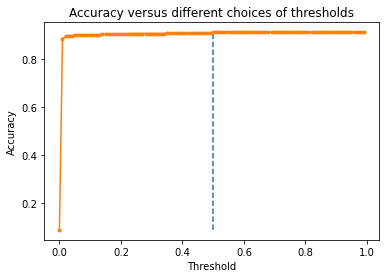

In [21]:
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# Calculate the accuracy using different values for the classification threshold, 
# and pick the threshold that resulted in the highest accuracy.
highest_accuracy = 0
threshold_highest_accuracy = 0

thresholds = np.arange(0,1,0.01) # Trying different boundaries
scores = []
for t in thresholds:
    # set threshold to 't' instead of 0.5
    y_test_other = (classifier.predict_proba(X_test)[:,1] >= t).astype(float)
    score = accuracy_score(y_test, y_test_other)
    scores.append(score)
    if(score > highest_accuracy):
        highest_accuracy = score
        threshold_highest_accuracy = t
print("Highest Accuracy on Test:", highest_accuracy, \
      ", Threshold for the highest Accuracy:", threshold_highest_accuracy)   

# Let's plot the accuracy versus different choices of thresholds
plt.plot([0.5, 0.5], [np.min(scores), np.max(scores)], linestyle='--')
plt.plot(thresholds, scores, marker='.')
plt.title('Accuracy versus different choices of thresholds')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.show()

This model has the same issue as the one before - it highly favors the dominant class.